In [1]:
import sys
sys.path.append("E:/university/Year 5 Spring/FYT/code/multi_modal_ser")
from utils.const import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Iterate through cut extraction map

In [2]:
video_rate = 30

from scipy.io import wavfile

spectrogramPATH = 'E:/datasets/preprocessed/spectrogram'

for ses in range(1, 2):
    extractionmapPATH = 'E:/datasets/preprocessed/extractionmap/cut_extractionmap' + \
        str(ses)+'.xlsx'
    xl = pd.ExcelFile(extractionmapPATH)
    sheets = xl.sheet_names
    spectrogramPATH = spectrogramPATH+'/Session'+str(ses)+'/'
    wavPATH = 'E:/datasets/IEMOCAP_full_release.tar/IEMOCAP_full_release/IEMOCAP_full_release/Session' + \
        str(ses)+'/dialog/wav/'
    for sheet in sheets:
        fileNAME = sheet+'.wav'
        spectrogramPATH = spectrogramPATH+fileNAME+'/'
        audio_rate, data = wavfile.read(wavPATH+fileNAME)
        sheet_df = xl.parse(sheet)
        iframe = np.array(sheet_df['iframe'])
        fframe = np.array(sheet_df['fframe'])
        smp_id = np.array(sheet_df['smp_id'])
        
        idx = 1
        
        multiframedata = data[iframe[idx]*int(audio_rate/video_rate):(fframe[idx]+1)*int(audio_rate/video_rate)]
        multiframedata = multiframedata.astype('float64').mean(axis=1)
        break  

### Encode spectrogram [librosa]

Raw Audio Shape: (29315,)
Mel Spectrogram: (128, 115)
STFT Shape: (1025, 115)
Inv Audio Shape: (29184,)


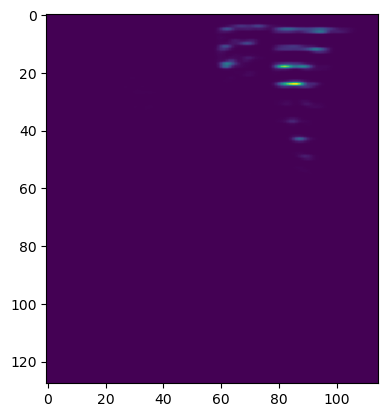

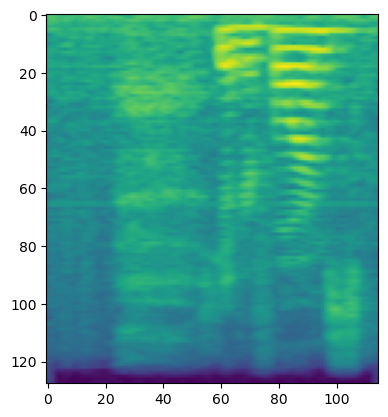

In [15]:
import librosa

raw_audio = multiframedata
mel = librosa.feature.melspectrogram(y=raw_audio, sr=audio_rate, hop_length=256)
stft = librosa.feature.inverse.mel_to_stft(mel)
inv_audio = librosa.griffinlim(stft, hop_length=256)

print("Raw Audio Shape:", raw_audio.shape)
print("Mel Spectrogram:", mel.shape)
print("STFT Shape:", stft.shape)
print("Inv Audio Shape:", inv_audio.shape)


plt.figure()
plt.imshow(mel)
plt.figure()
plt.imshow(np.log(mel))

1

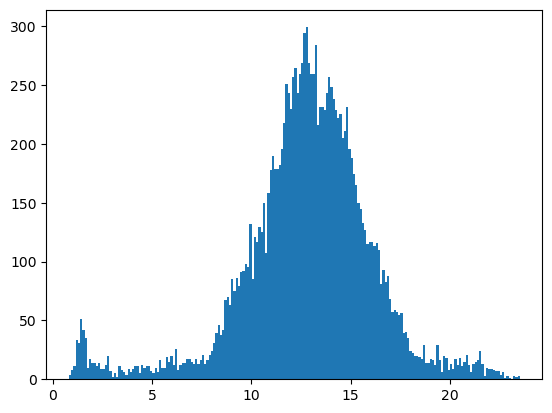

In [16]:
plt.hist(np.log(mel).reshape(-1), bins=200)
1

In [17]:
from IPython.display import Audio

Audio(raw_audio, rate=audio_rate)

In [18]:
Audio(inv_audio, rate=audio_rate)

### Encode spectrum [ASTFeatureExtractor]

In [7]:
from transformers import ASTFeatureExtractor, ASTModel
import torch

processor = ASTFeatureExtractor(max_length=200, do_normalize=False)
inputs = processor(raw_audio, sampling_rate=audio_rate, return_tensors="pt")
ast_spec = inputs["input_values"][0].T

torch.Size([128, 200])


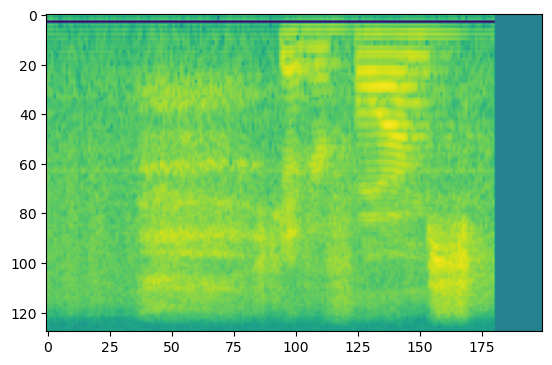

In [8]:
print(ast_spec.shape)
plt.imshow(ast_spec)

1

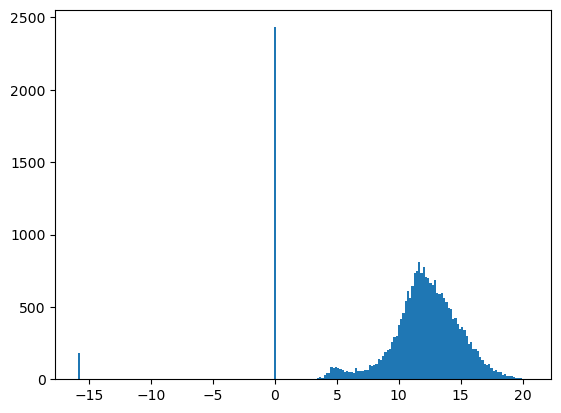

In [9]:
plt.hist(ast_spec.reshape(-1), bins=200)
1

The graphs looks similar? Maybe some params are different?

In [20]:
ast_stft = librosa.feature.inverse.mel_to_stft(np.exp(ast_spec.numpy()))
ast_audio = librosa.griffinlim(ast_stft, hop_length=200)
Audio(ast_audio, rate=audio_rate)

### Summary
To-Check (from other papers):
1. do_normalize
2. n_fft
3. hop_length